# Part (b)
In this part a hidden layer is introduced with ReLU non-linearity followed by a linear layer and softmax.

In [1]:
# Need to excute this line first
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import os

In [2]:
# Need to load the MNist data to work with
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)
# one hot true gives the y labels as vectors with 1's which correspond to the number it is

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


### Data dimenions

In [3]:
im_size = 28
im_flat = im_size**2

# Also have a dimsension of 10 for the one hot vectors.
num_digits = 10

### Placeholders for data

In [4]:
# need placeholders for the inputs to train, x, and the true labels
x = tf.placeholder( tf.float32, shape =[None, im_flat])
# None is used as it the number of images to be used is not yet defined
# possible to pass throught any size data, with 784 features(pixels)

# Create a placeholder for the y labels
y_label = tf.placeholder( tf.float32, shape = [None, num_digits])

# Since y_labels are one hot vectors, get the actual digit label.
y_digit = tf.argmax(y_label, dimension = 1)


### Variables
Using functions enable us to create a fully connected layer easily later on so changing shape of the different weight and bias variables is done here.

In [5]:
# Need to define Variables that will be optimized

# The Dimensionality of the weight vector to be able to multiply with 
# x and won't havr
def W(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    #return tf.Variable(tf.zeros(shape))
    
    
def b(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
    #return tf.Variable(tf.zeros(length))

## Fully connected layer.
This function takes an input, initialy $\bf{X}$, then the output of then non linear layer. The number of inputs is the flatend pixels, and then 128 units for the second layer. Since we know how many units we want, we can specify that too, initially 128 units, then 10 classes. Since we have a ReLU in the hidden layer and only a linear layer in the second, the ReLU argument allows us to implement an activation if we like. 


In [6]:
def fc_layer(input, num_inputs, num_outputs,use_relu=True):       
    # The previous layer, Num. inputs from prev. layer, Num. outputs.
    # Use ReLU?

    # Create new weights and biases.
    weights = W(shape=[num_inputs, num_outputs])
    biases = b(length=num_outputs)

    # Do the linear layer by simply doing matrix multiplication
    # and adding the bias terms.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Non Linear layer.
Takes in $\bf{X}$ as its input , applies linear transformation followed by ReLU activation and outputs 128 units.

In [7]:
layer_fc1 = fc_layer(input=x,
                         num_inputs=im_flat,
                         num_outputs=128,
                         use_relu=True)

### Linear layer
A linear transformation is applied to the output from the nonlinear layer, note that no activation is used here 

In [8]:
layer_fc2 = fc_layer(input=layer_fc1,
                         num_inputs=128,
                         num_outputs=num_digits,
                         use_relu=False)

### Softmax layer
Softmax is applied to the output from the second layer

In [9]:
# Do softmax
y_pred_label= tf.nn.softmax(layer_fc2)

# Get the digit
y_pred_digit = tf.argmax(y_pred_label, dimension = 1)

### Cross-entropy 
This is applied to the output of the linear layer since the softmax calculation is calculated in the cross-entopy term.

In [10]:
# As advised in the CW, the Xent loss function is used
# Xent function in TesorFlow actually takes care of the soft max
# layer when it takes its inputs, so will use the linear layer ouput
# as the input

Xent = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc2, labels = y_label)

In [11]:
# Need to take the average over the images for each classification
cost = tf.reduce_mean(Xent)

### Optimizer object
Use gradient descent to optimize the cost. The stochastic part comes from using randfom batches.

In [12]:
# The object is created to pass the cost function through
# The stocastic process comes from using small batch samples
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)

In [13]:
# create a boolean of correct labels and take the average to 
# get the percentage of correctly available
correct_label = tf.equal(y_digit,y_pred_digit)

# cast is used to convert the data type to a float 
accuracy = tf.reduce_mean(tf.cast(correct_label, tf.float32))

### Optimizer function.
This function runs the optimization for as many iterations as inputed. The batch size is predefined.

In [14]:
count = 0
feed_dict_test = {x: data.test.images,
                           y_label: data.test.labels}

def optimize(iters,print_num):
    
    global count
    freq = iters/print_num
    train_acc =[]
    train_loss = []
    test_acc = []
    test_loss =[]
    length = np.linspace(1,iters,print_num)
    for i in range(iters):
        
        # Get the batch images, x, and labels,y.
        x_batch, y_batch = data.train.next_batch(batch_size)

        # need a dictionary which feeds the batches into the 
        # placeholder values
        train_dict = {x: x_batch,y_label: y_batch}
        
        sess.run(optimizer,feed_dict = train_dict)
        # after each 100 iterations calculater the train error
        if i % freq ==0:
            
            # Calculate accuracy of the train error
            accuracy_train = sess.run(accuracy,feed_dict=train_dict)
            loss_train = sess.run(cost,feed_dict=train_dict)
            train_acc.append(accuracy_train)
            train_loss.append(loss_train)
            
            accuracy_test = sess.run(accuracy,feed_dict=feed_dict_test)
            loss_test = sess.run(cost,feed_dict=feed_dict_test)
            test_acc.append(accuracy_test)
            test_loss.append(loss_test)
            
            print("iteration:{0:>6}, \t\t Train Accuracy:{1:6.1%}\n".format(1+i, accuracy_train))
            print("\t\t \t\t Test Accuracy:{1:6.1%}\n".format(1+i, accuracy_test))
            
    return(train_acc,test_acc,length,train_loss,test_loss)        
count += count 

### Saving the Model

In [15]:
# Need to save the model, weights and biases varibles
saver = tf.train.Saver()

# Suggested Directory to use
save_MDir = 'models/'


#create the directory if it does not exist already
if not os.path.exists(save_MDir):
    os.makedirs(save_MDir)

save_model = os.path.join(save_MDir,'best_accuracyb')    

### Run Session

In [16]:
sess = tf.Session()

In [17]:
sess.run(tf.global_variables_initializer())
# need to start up the variables

In [18]:
batch_size = 500

In [19]:
# Allocate an array for the predicted classes which
# will be calculated in batches and filled into this array.


# Need to create test dictionary set
test_dict = {x: data.test.images, y_label: data.test.labels}


### Accuracy

In [20]:

def print_acc():
    train_dict = {x: data.train.images, y_label: data.train.labels}
    test_dict = {x: data.test.images, y_label: data.test.labels}
    acc_train = sess.run(accuracy,feed_dict = train_dict)
    acc_test  = sess.run(accuracy,feed_dict = test_dict)
    
    print("Training Accuracy: {0:.1%} \n".format(acc_train))
    print("Test Accuracy: {0:.1%} \n".format(acc_test))

In [21]:
print_acc()

Training Accuracy: 9.6% 

Test Accuracy: 9.6% 



### 10 iterations

In [22]:
[train_acc10,test_acc10,length10,train_loss10,test_loss10] = optimize(iters = 10,print_num = 10)
print_acc()

iteration:     1, 		 Train Accuracy: 36.0%

		 		 Test Accuracy: 30.5%

iteration:     2, 		 Train Accuracy: 55.0%

		 		 Test Accuracy: 46.0%

iteration:     3, 		 Train Accuracy: 73.6%

		 		 Test Accuracy: 66.5%

iteration:     4, 		 Train Accuracy: 68.4%

		 		 Test Accuracy: 65.9%

iteration:     5, 		 Train Accuracy: 67.8%

		 		 Test Accuracy: 68.7%

iteration:     6, 		 Train Accuracy: 72.0%

		 		 Test Accuracy: 70.1%

iteration:     7, 		 Train Accuracy: 67.4%

		 		 Test Accuracy: 65.4%

iteration:     8, 		 Train Accuracy: 56.8%

		 		 Test Accuracy: 57.5%

iteration:     9, 		 Train Accuracy: 64.0%

		 		 Test Accuracy: 57.4%

iteration:    10, 		 Train Accuracy: 68.8%

		 		 Test Accuracy: 65.9%

Training Accuracy: 64.8% 

Test Accuracy: 65.9% 



### Accuracy Plot

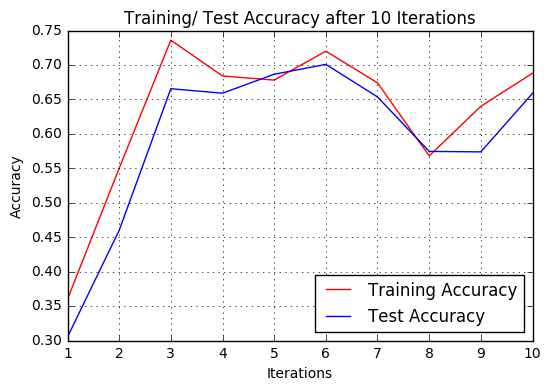

In [23]:
plt.title('Training/ Test Accuracy after 10 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.grid(True)
plt.plot(length10,train_acc10,color="red", label="Training Accuracy")
plt.plot(length10,test_acc10,color="blue", label="Test Accuracy")

plt.legend( loc='lower right')
plt.savefig("Accuracy_10b.png", bbox_inches='tight')
plt.show()

### Loss plot

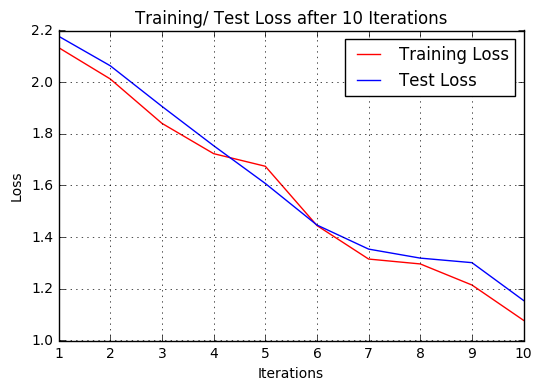

In [24]:
plt.title('Training/ Test Loss after 10 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.grid(True)
plt.plot(length10,train_loss10,color="red", label="Training Loss")
plt.plot(length10,test_loss10,color="blue", label="Test Loss")

plt.legend( loc='upper right')
plt.savefig("Loss_10b.png", bbox_inches='tight')
plt.show()

In [25]:
sess.run(tf.global_variables_initializer())

### 10,000 iterations

In [26]:
[train_acc,test_acc,length,train_loss,test_loss] = optimize(iters = 10000,print_num = 50)
print_acc()

iteration:     1, 		 Train Accuracy: 50.4%

		 		 Test Accuracy: 42.1%

iteration:   201, 		 Train Accuracy: 94.6%

		 		 Test Accuracy: 93.5%

iteration:   401, 		 Train Accuracy: 95.8%

		 		 Test Accuracy: 95.2%

iteration:   601, 		 Train Accuracy: 98.4%

		 		 Test Accuracy: 96.0%

iteration:   801, 		 Train Accuracy: 98.6%

		 		 Test Accuracy: 96.7%

iteration:  1001, 		 Train Accuracy: 97.8%

		 		 Test Accuracy: 97.0%

iteration:  1201, 		 Train Accuracy: 98.6%

		 		 Test Accuracy: 97.1%

iteration:  1401, 		 Train Accuracy: 99.2%

		 		 Test Accuracy: 97.4%

iteration:  1601, 		 Train Accuracy: 99.8%

		 		 Test Accuracy: 97.5%

iteration:  1801, 		 Train Accuracy: 99.8%

		 		 Test Accuracy: 97.7%

iteration:  2001, 		 Train Accuracy:100.0%

		 		 Test Accuracy: 97.7%

iteration:  2201, 		 Train Accuracy:100.0%

		 		 Test Accuracy: 97.8%

iteration:  2401, 		 Train Accuracy: 99.2%

		 		 Test Accuracy: 97.7%

iteration:  2601, 		 Train Accuracy: 99.4%

		 		 Test Accuracy:

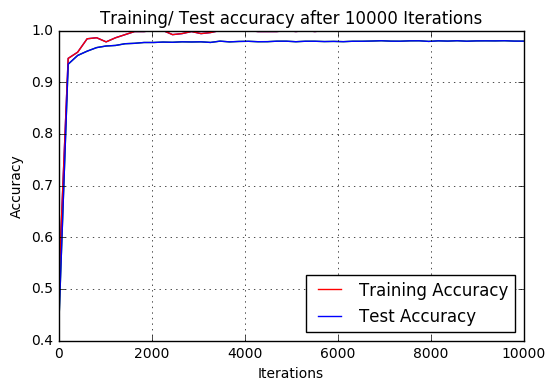

In [27]:
plt.title('Training/ Test accuracy after 10000 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.grid(True)
plt.plot(length,train_acc)
plt.plot(length,test_acc)
plt.plot(length,train_acc,color="red", label="Training Accuracy")
fig = plt.plot(length,test_acc,color="blue", label="Test Accuracy")


plt.legend( loc='lower right')
plt.savefig("Accuracy_10000b.png", bbox_inches='tight')
plt.show()


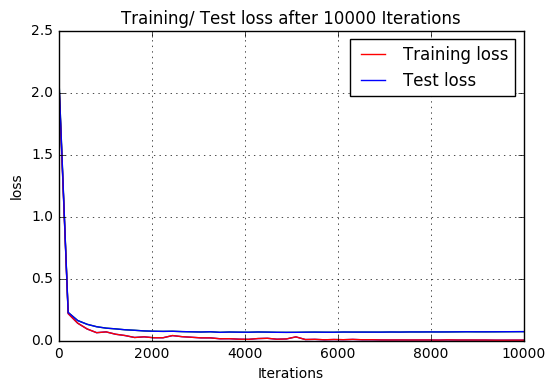

In [28]:
plt.title('Training/ Test loss after 10000 Iterations')
plt.xlabel('Iterations')
plt.ylabel('loss')

plt.grid(True)
plt.plot(length,train_loss)
plt.plot(length,test_loss)
plt.plot(length,train_loss,color="red", label="Training loss")
plt.plot(length,test_loss,color="blue", label="Test loss")
plt.legend( loc='upper right')
plt.savefig("Loss_10000b.png", bbox_inches='tight')
plt.show()

### Confusion Matrix

[[ 969    0    2    0    2    1    2    2    2    0]
 [   0 1126    2    1    0    1    2    1    2    0]
 [   3    3 1009    3    2    0    1    6    5    0]
 [   0    1    4  992    0    3    0    2    4    4]
 [   1    0    3    0  967    0    1    4    2    4]
 [   2    0    0   11    2  860    7    1    6    3]
 [   5    4    1    1    5    3  939    0    0    0]
 [   0    2    8    5    1    0    0 1003    3    6]
 [   3    0    3    5    3    2    3    4  949    2]
 [   3    2    1    7   10    0    0    4    3  979]]


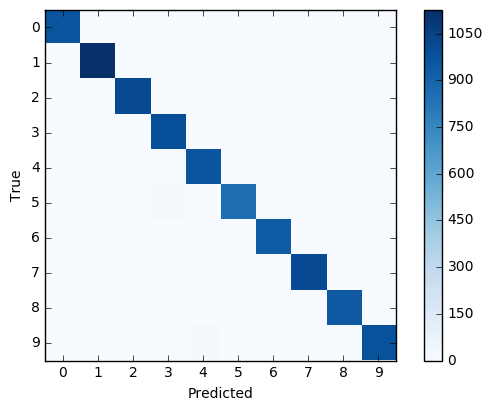

In [29]:
#defined the actual digits of labels again
y_true = data.test.labels
y_true_digit = np.argmax(y_true,axis = 1)

feed_dict_test = {x: data.test.images,
                           y_label: data.test.labels}
# find the predicted labels
y_pred = sess.run(y_pred_digit, feed_dict = feed_dict_test)

# get the confusion matrix
conf_mat = confusion_matrix( y_true_digit,
                             y_pred)
print(conf_mat)
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(num_digits)
plt.xticks(tick_marks, range(num_digits))
plt.yticks(tick_marks, range(num_digits))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("CM_10000b.png", bbox_inches='tight')
plt.show()

Here it can be seen where the digits have been misclassified. For exammple the number nine gets classified as 7 or a 4 sometimes. 7 is understandable as depending on what way people write their sevens may appear simlar to nine

In [30]:
saver.save(sess= sess, save_path = save_model)

'models/best_accuracyb'

In [31]:
sess.close()

In [32]:
save_MDir = 'models/'
save_model = os.path.join(save_MDir,'best_accuracyb')    
saver2restore = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2restore.restore(sess = sess, save_path= save_model)
    print("Restored values:\n")
    #print('Weights: \t')
    #print(sess.run(W))
    
    #print('\n Biases:')
    #print(sess.run(b))
    print('\n')
    print_acc()

Restored values:

Weights: 	

 Biases:


Training Accuracy: 100.0% 

Test Accuracy: 97.9% 



# Run the saved model notebook to check if the accuracy is the same as in the report.